 # Chicago Health Equity Index: Data Engineering : High level initial look
   * Data is collected at the census tract level where possible. Various data features can be grouped into the following catagories: **Economic, Transportation, Education, and Safety**
   * Response feature is csv extract from the CDC: https://www.cdc.gov/nchs/data-visualization/life-expectancy/index.html# 
   * Model features are called via US Census API and SOCRATA API via City of Chicago Data Portal

   * Census data collected from the API of the ACS 5 year from 2015 at the data profile level: Data Dictionary can be found here: https://api.census.gov/data/2015/acs/acs5/profile/variables.html

   * Additional Census Data can be added from the detailed tables here: https://www.census.gov/data/developers/data-sets/acs-5year.html
        * **Detailed Tables** contain the most detailed cross-tabulations, many of which are published down to block groups. The data are population counts. There are over 20,000 variables in this dataset.
        * **Subject Tables** provide an overview of the estimates available in a particular topic.  The data are presented as population counts and percentages.  There are over 18,000 variables in this dataset. 
        * **Data Profiles** contain broad social, economic, housing, and demographic information. The data are presented as population counts and percentages. There are over 1,000 variables in this dataset.
        * **Comparison Profiles** are similar to Data Profiles but also include comparisons with past-year data.  The current year data are compared with prior 5-Year data and include statistical significance testing.  There are over 1,000 variables in this dataset.

The county health index developed by the University of Wisconsin studies health outcomes 
* https://www.countyhealthrankings.org/explore-health-rankings/county-health-rankings-model/health-outcomes?year=2023&county=17031

We focussed on the social and economic features

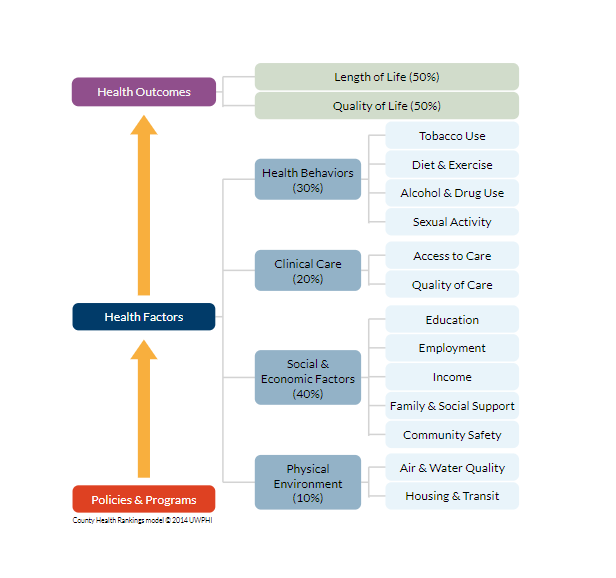

## Import Libraries, Functions, and Flat Files

In [1]:
#Import Libraries
from secrets import *
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from census import Census
from us import states
from datetime import datetime
from sodapy import Socrata

In [2]:
#Import Flat Files
life_expectancy = pd.read_csv('LifeExp.csv')
chicago_tracts=pd.read_csv('Chicago_Tracts.csv')

In [3]:
#Define API Call Functions

def get_census_dp(variables,year=2015):
    c=Census(census_key, year=year)
    # Get the ACS data
    variable_codes=list(variables.values())
    variable_codes.append('NAME')
    data = c.acs5dp.state_county_tract(variable_codes, states.IL.fips, '031', Census.ALL)
    
    # Convert to DataFrame
    census_df = pd.DataFrame(data)
    census_df['tract']=census_df['tract'].astype(int)
    census_df['tract']=census_df['tract'].astype(str)
    
    # Rename columns based on the variable_map keys
    reverse_map = {v: k for k, v in variables.items()}  # Reverse the mapping for renaming
    census_df.rename(columns=reverse_map, inplace=True)

    return census_df

def get_census_dt(variable_codes):
    # Get the ACS data
    variable_codes.append('NAME')
    data = c.acs5.state_county_tract(variable_codes, states.IL.fips, '031', Census.ALL)
    
    # Convert to DataFrame
    census_df = pd.DataFrame(data)
    census_df['tract']=census_df['tract'].astype(int)
    census_df['tract']=census_df['tract'].astype(str)
    
    return census_df

In [4]:
# Example usage
variables= {
    'Insured_Pe': 'DP03_0096PE',
    'NonInsured_Pe': 'DP03_0099PE'
}

df_test=get_census_dp(variables)
df_test.head()

,Insured_Pe,NonInsured_Pe,NAME,state,county,tract
0,86.2,13.8,"Census Tract 2714, Cook County, Illinois",17,031,271400
1,96.4,3.6,"Census Tract 2801, Cook County, Illinois",17,031,280100
2,83.2,16.8,"Census Tract 8235, Cook County, Illinois",17,031,823500
3,86.5,13.5,"Census Tract 8215, Cook County, Illinois",17,031,821500
4,94.2,5.8,"Census Tract 8218, Cook County, Illinois",17,031,821800


## Response Variables: Length of Life and Quality of Life

In [5]:
life_expectancy = life_expectancy[(life_expectancy['State'] == 'Illinois') & (life_expectancy['County'].str.contains('Cook'))]

In [6]:
life_expectancy['Tract'] = life_expectancy['Census Tract Number']
life_expectancy['Tract'] = life_expectancy['Tract']*100
life_expectancy['tract'] = life_expectancy['Tract'].astype(int).astype(str)
life_expectancy.head()

,State,County,Census Tract Number,Life Expectancy,Life Expectancy Range,Life Expectancy Standard Error,Tract,tract
21114,Illinois,"Cook County, IL",101.00,68.8,56.9-75.1,1.7306,10100.0,10100
21115,Illinois,"Cook County, IL",102.01,77.3,75.2-77.5,1.9253,10201.0,10201
21116,Illinois,"Cook County, IL",102.02,78.6,77.6-79.5,1.3567,10202.0,10202
21117,Illinois,"Cook County, IL",103.00,70.0,56.9-75.1,1.0274,10300.0,10300
21118,Illinois,"Cook County, IL",104.00,79.7,79.6-81.6,1.9647,10400.0,10400


### Filter Response to Only Chicago Tracts

In [7]:
chicago_tracts['tract']=chicago_tracts['TRACTCE10']
chicago_tracts['tract']=chicago_tracts['tract'].astype(str)

In [8]:
life_expectancy = pd.merge(life_expectancy,chicago_tracts, on='tract', how='inner')
life_expectancy.head()

,State,County,Census Tract Number,Life Expectancy,Life Expectancy Range,Life Expectancy Standard Error,Tract,tract,geometry_,STATEFP10,COUNTYFP10,TRACTCE10,geoid,NAME10,NAMELSAD10,commarea,neighborhood,area
0,Illinois,"Cook County, IL",101.00,68.8,56.9-75.1,1.7306,10100.0,10100,MULTIPOLYGON (((-87.66368000002299 42.01939800...,17,31,10100,17031010100,101.00,Census Tract 101,1,ROGERS PARK,Far North Side
1,Illinois,"Cook County, IL",102.01,77.3,75.2-77.5,1.9253,10201.0,10201,MULTIPOLYGON (((-87.6800950000417 42.012537999...,17,31,10201,17031010201,102.01,Census Tract 102.01,1,ROGERS PARK,Far North Side
2,Illinois,"Cook County, IL",102.02,78.6,77.6-79.5,1.3567,10202.0,10202,MULTIPOLYGON (((-87.67335799998422 42.01937400...,17,31,10202,17031010202,102.02,Census Tract 102.02,1,ROGERS PARK,Far North Side
3,Illinois,"Cook County, IL",103.00,70.0,56.9-75.1,1.0274,10300.0,10300,MULTIPOLYGON (((-87.66505999995483 42.01280100...,17,31,10300,17031010300,103.00,Census Tract 103,1,ROGERS PARK,Far North Side
4,Illinois,"Cook County, IL",104.00,79.7,79.6-81.6,1.9647,10400.0,10400,MULTIPOLYGON (((-87.65080299995667 41.99848500...,17,31,10400,17031010400,104.00,Census Tract 104,1,ROGERS PARK,Far North Side


### Test Join on Tract Level

In [10]:
merge_df=pd.merge(df_test, life_expectancy, on='tract', how='inner')
merge_df.head()

,Insured_Pe,NonInsured_Pe,NAME,state,county,tract,State,County,Census Tract Number,Life Expectancy,...,geometry_,STATEFP10,COUNTYFP10,TRACTCE10,geoid,NAME10,NAMELSAD10,commarea,neighborhood,area
0,86.2,13.8,"Census Tract 2714, Cook County, Illinois",17,031,271400,Illinois,"Cook County, IL",2714.0,68.6,...,MULTIPOLYGON (((-87.71080299996187 41.87426299...,17,31,271400,17031271400,2714.0,Census Tract 2714,27,EAST GARFIELD PARK,West Side
1,96.4,3.6,"Census Tract 2801, Cook County, Illinois",17,031,280100,Illinois,"Cook County, IL",2801.0,NaN,...,MULTIPOLYGON (((-87.64571900003747 41.88179600...,17,31,280100,17031280100,2801.0,Census Tract 2801,28,NEAR WEST SIDE,West Side
2,68.6,31.4,"Census Tract 3103, Cook County, Illinois",17,031,310300,Illinois,"Cook County, IL",3103.0,79.1,...,MULTIPOLYGON (((-87.64926400002443 41.85259500...,17,31,310300,17031310300,3103.0,Census Tract 3103,31,LOWER WEST SIDE,West Side
3,78.1,21.9,"Census Tract 2002, Cook County, Illinois",17,031,200200,Illinois,"Cook County, IL",2002.0,78.5,...,MULTIPOLYGON (((-87.74165199997601 41.93159800...,17,31,200200,17031200200,2002.0,Census Tract 2002,20,HERMOSA,Northwest Side
4,75.8,24.2,"Census Tract 2214, Cook County, Illinois",17,031,221400,Illinois,"Cook County, IL",2214.0,80.9,...,MULTIPOLYGON (((-87.69738199997865 41.92358800...,17,31,221400,17031221400,2214.0,Census Tract 2214,22,LOGAN SQUARE,North Side


## Feature List

In [11]:
features= {
'Population': 'DP05_0001E',
'Poverty': 'DP03_0119PE',
'Income': 'DP03_0062E',
'Unemployment': 'DP03_0009PE',
'Education': 'DP02_0066PE',
'Healthcare': 'DP03_0099PE',
'Insurance': 'DP03_0096PE',
'Rent':'DP04_0134E'
}

## Call API Data

In [12]:
features_df=get_census_dp(features)
features_df.head()

,Population,Poverty,Income,Unemployment,Education,Healthcare,Insurance,Rent,NAME,state,county,tract
0,1185.0,43.3,21742.0,17.5,74.1,13.8,86.2,813.0,"Census Tract 2714, Cook County, Illinois",17,031,271400
1,6811.0,0.0,109286.0,3.0,100.0,3.6,96.4,1971.0,"Census Tract 2801, Cook County, Illinois",17,031,280100
2,4643.0,13.3,46962.0,16.9,85.0,16.8,83.2,961.0,"Census Tract 8235, Cook County, Illinois",17,031,823500
3,1858.0,27.4,40278.0,20.6,83.5,13.5,86.5,1043.0,"Census Tract 8215, Cook County, Illinois",17,031,821500
4,5369.0,4.5,63652.0,10.1,92.0,5.8,94.2,960.0,"Census Tract 8218, Cook County, Illinois",17,031,821800


In [13]:
features_df['RentBurden'] = features_df['Rent'] / (features_df['Income']/12)

In [14]:
features_df

,Population,Poverty,Income,Unemployment,Education,Healthcare,Insurance,Rent,NAME,state,county,tract,RentBurden
0,1185.0,43.3,21742.0,17.5,74.1,13.8,86.2,813.0,"Census Tract 2714, Cook County, Illinois",17,031,271400,0.448717
1,6811.0,0.0,109286.0,3.0,100.0,3.6,96.4,1971.0,"Census Tract 2801, Cook County, Illinois",17,031,280100,0.216423
2,4643.0,13.3,46962.0,16.9,85.0,16.8,83.2,961.0,"Census Tract 8235, Cook County, Illinois",17,031,823500,0.245560
3,1858.0,27.4,40278.0,20.6,83.5,13.5,86.5,1043.0,"Census Tract 8215, Cook County, Illinois",17,031,821500,0.310740
4,5369.0,4.5,63652.0,10.1,92.0,5.8,94.2,960.0,"Census Tract 8218, Cook County, Illinois",17,031,821800,0.180984
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1314,3426.0,4.0,96833.0,2.6,100.0,5.1,94.9,1605.0,"Census Tract 703, Cook County, Illinois",17,031,70300,0.198899
1315,6558.0,7.6,37338.0,9.1,86.9,22.3,77.7,875.0,"Census Tract 106, Cook County, Illinois",17,031,10600,0.281215
1316,4518.0,19.9,56419.0,11.2,86.1,18.0,82.0,1020.0,"Census Tract 204, Cook County, Illinois",17,031,20400,0.216948
1317,3801.0,2.5,66875.0,5.9,94.4,13.2,86.8,1131.0,"Census Tract 310, Cook County, Illinois",17,031,31000,0.202946


## Joined Model and Export

In [15]:
#merge
model=pd.merge(features_df, life_expectancy, on='tract', how='inner')
model.head()

,Population,Poverty,Income,Unemployment,Education,Healthcare,Insurance,Rent,NAME,state,...,geometry_,STATEFP10,COUNTYFP10,TRACTCE10,geoid,NAME10,NAMELSAD10,commarea,neighborhood,area
0,1185.0,43.3,21742.0,17.5,74.1,13.8,86.2,813.0,"Census Tract 2714, Cook County, Illinois",17,...,MULTIPOLYGON (((-87.71080299996187 41.87426299...,17,31,271400,17031271400,2714.0,Census Tract 2714,27,EAST GARFIELD PARK,West Side
1,6811.0,0.0,109286.0,3.0,100.0,3.6,96.4,1971.0,"Census Tract 2801, Cook County, Illinois",17,...,MULTIPOLYGON (((-87.64571900003747 41.88179600...,17,31,280100,17031280100,2801.0,Census Tract 2801,28,NEAR WEST SIDE,West Side
2,1673.0,14.2,39331.0,14.4,77.7,31.4,68.6,919.0,"Census Tract 3103, Cook County, Illinois",17,...,MULTIPOLYGON (((-87.64926400002443 41.85259500...,17,31,310300,17031310300,3103.0,Census Tract 3103,31,LOWER WEST SIDE,West Side
3,4815.0,26.9,36416.0,11.4,62.7,21.9,78.1,934.0,"Census Tract 2002, Cook County, Illinois",17,...,MULTIPOLYGON (((-87.74165199997601 41.93159800...,17,31,200200,17031200200,2002.0,Census Tract 2002,20,HERMOSA,Northwest Side
4,3034.0,12.7,63261.0,3.6,86.6,24.2,75.8,971.0,"Census Tract 2214, Cook County, Illinois",17,...,MULTIPOLYGON (((-87.69738199997865 41.92358800...,17,31,221400,17031221400,2214.0,Census Tract 2214,22,LOGAN SQUARE,North Side


In [16]:
model.describe()

,Population,Poverty,Income,Unemployment,Education,Healthcare,Insurance,Rent,RentBurden,Census Tract Number,Life Expectancy,Life Expectancy Standard Error,Tract,STATEFP10,COUNTYFP10,TRACTCE10,geoid,NAME10,commarea
count,800.00000,8.000000e+02,8.000000e+02,8.000000e+02,8.000000e+02,8.000000e+02,8.000000e+02,8.000000e+02,800.000000,800.000000,701.000000,701.000000,800.000000,800.0,800.0,800.000000,8.000000e+02,800.000000,800.000000
mean,3422.36750,-2.499980e+06,-3.561664e+06,-2.499986e+06,-2.499919e+06,-2.499984e+06,-2.499917e+06,-6.943456e+06,-683.617543,4058.249075,76.621826,2.158328,405824.907500,17.0,31.0,405824.905000,1.703141e+10,4058.249050,34.946250
std,1807.37722,4.077370e+07,5.142903e+07,4.077370e+07,4.077371e+07,4.077370e+07,4.077371e+07,6.952967e+07,9173.967806,2778.272753,4.666589,0.704843,277827.275273,0.0,0.0,277827.278655,2.778273e+05,2778.272787,22.761832
min,0.00000,-6.666667e+08,-8.888889e+08,-6.666667e+08,-6.666667e+08,-6.666667e+08,-6.666667e+08,-8.888889e+08,-180180.180000,101.000000,59.900000,0.874700,10100.000000,17.0,31.0,10100.000000,1.703101e+10,101.000000,1.000000
25%,1987.75000,7.100000e+00,2.937500e+04,6.875000e+00,7.370000e+01,9.900000e+00,7.780000e+01,8.327500e+02,0.206298,1609.750000,73.300000,1.618200,160975.000000,17.0,31.0,160975.000000,1.703116e+10,1609.750000,16.000000
50%,3081.50000,1.750000e+01,4.228700e+04,1.185000e+01,8.360000e+01,1.620000e+01,8.370000e+01,9.320000e+02,0.260563,3558.500000,77.200000,2.023500,355850.000000,17.0,31.0,355850.000000,1.703136e+10,3558.500000,29.000000
75%,4568.00000,2.950000e+01,6.197725e+04,1.980000e+01,9.180000e+01,2.220000e+01,9.000000e+01,1.086000e+03,0.337986,6704.250000,80.300000,2.581000,670425.000000,17.0,31.0,670425.000000,1.703167e+10,6704.250000,56.000000
max,17935.00000,7.230000e+01,1.604550e+05,9.190000e+01,1.000000e+02,4.500000e+01,9.960000e+01,2.768000e+03,12.000000,9801.000000,90.000000,3.947000,980100.000000,17.0,31.0,980100.000000,1.703198e+10,9801.000000,77.000000


In [17]:
#Clean model
model=model.dropna()
model.describe()

,Population,Poverty,Income,Unemployment,Education,Healthcare,Insurance,Rent,RentBurden,Census Tract Number,Life Expectancy,Life Expectancy Standard Error,Tract,STATEFP10,COUNTYFP10,TRACTCE10,geoid,NAME10,commarea
count,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,7.010000e+02,701.000000,701.000000,701.000000,701.000000,701.000000,701.0,701.0,701.000000,7.010000e+02,701.000000,701.000000
mean,3567.746077,20.240942,47843.895863,14.972183,80.800000,16.949501,83.050499,-5.071151e+06,-780.251902,4139.881683,76.621826,2.158328,413988.168331,17.0,31.0,413988.165478,1.703141e+10,4139.881655,36.121255
std,1796.354268,14.576501,24547.897673,9.780490,12.731735,8.251730,8.251730,6.035459e+07,9797.396779,2752.881786,4.666589,0.704843,275288.178634,0.0,0.0,275288.182616,2.752882e+05,2752.881826,22.871214
min,859.000000,0.000000,9845.000000,0.000000,40.300000,0.400000,55.900000,-8.888889e+08,-180180.180000,101.000000,59.900000,0.874700,10100.000000,17.0,31.0,10100.000000,1.703101e+10,101.000000,1.000000
25%,2141.000000,8.000000,29375.000000,7.700000,73.300000,10.700000,77.700000,8.260000e+02,0.208277,1706.000000,73.300000,1.618200,170600.000000,17.0,31.0,170600.000000,1.703117e+10,1706.000000,17.000000
50%,3244.000000,18.000000,41607.000000,12.300000,82.600000,16.600000,83.400000,9.280000e+02,0.262886,4004.000000,77.200000,2.023500,400400.000000,17.0,31.0,400400.000000,1.703140e+10,4004.000000,30.000000
75%,4736.000000,30.000000,59759.000000,20.200000,90.400000,22.300000,89.300000,1.044000e+03,0.339177,6711.000000,80.300000,2.581000,671100.000000,17.0,31.0,671100.000000,1.703167e+10,6711.000000,58.000000
max,17935.000000,72.300000,147596.000000,54.100000,100.000000,44.100000,99.600000,2.768000e+03,0.796556,8439.000000,90.000000,3.947000,843900.000000,17.0,31.0,843900.000000,1.703184e+10,8439.000000,77.000000


In [18]:
#show me records where RentBurden is less than 0
#show all columns in pandas
pd.set_option('display.max_columns', None)

model[model['RentBurden'] < 0]

,Population,Poverty,Income,Unemployment,Education,Healthcare,Insurance,Rent,NAME,state,county,tract,RentBurden,State,County,Census Tract Number,Life Expectancy,Life Expectancy Range,Life Expectancy Standard Error,Tract,geometry_,STATEFP10,COUNTYFP10,TRACTCE10,geoid,NAME10,NAMELSAD10,commarea,neighborhood,area
78,4024.0,1.2,107837.0,6.5,98.6,0.4,99.6,-666666666.0,"Census Tract 7203, Cook County, Illinois",17,031,720300,-74186.039968,Illinois,"Cook County, IL",7203.00,81.9,81.7-97.5,1.6339,720300.0,MULTIPOLYGON (((-87.68041700002094 41.70638299...,17,31,720300,17031720300,7203.00,Census Tract 7203,72,BEVERLY,Far Southwest Side
121,5617.0,0.0,97232.0,1.3,94.8,0.7,99.3,-666666666.0,"Census Tract 1005, Cook County, Illinois",17,031,100500,-82277.439444,Illinois,"Cook County, IL",1005.00,79.0,77.6-79.5,1.3769,100500.0,MULTIPOLYGON (((-87.80701000002459 41.97709799...,17,31,100500,17031100500,1005.00,Census Tract 1005,10,NORWOOD PARK,Far North Side
151,1504.0,10.1,44400.0,18.0,69.2,16.0,84.0,-666666666.0,"Census Tract 5604, Cook County, Illinois",17,031,560400,-180180.180000,Illinois,"Cook County, IL",5604.00,75.8,75.2-77.5,1.9763,560400.0,MULTIPOLYGON (((-87.7399009999709 41.800362000...,17,31,560400,17031560400,5604.00,Census Tract 5604,56,GARFIELD RIDGE,Southwest Side
237,3162.0,8.8,85833.0,15.6,88.1,5.7,94.3,-888888888.0,"Census Tract 7005.02, Cook County, Illinois",17,031,700502,-124272.327147,Illinois,"Cook County, IL",7005.02,76.0,75.2-77.5,1.5599,700502.0,MULTIPOLYGON (((-87.69336300002485 41.73534499...,17,31,700502,17031700502,7005.02,Census Tract 7005.02,70,ASHBURN,Far Southwest Side
324,6466.0,5.6,92764.0,8.0,94.2,2.6,97.4,-666666666.0,"Census Tract 7402, Cook County, Illinois",17,031,740200,-86240.351774,Illinois,"Cook County, IL",7402.00,80.5,79.6-81.6,1.3225,740200.0,MULTIPOLYGON (((-87.72079000004294 41.70309599...,17,31,740200,17031740200,7402.00,Census Tract 7402,74,MOUNT GREENWOOD,Far Southwest Side


In [19]:
#export
final_model=model
final_model.to_csv('initial_model.csv')

# EDA and Initial Models

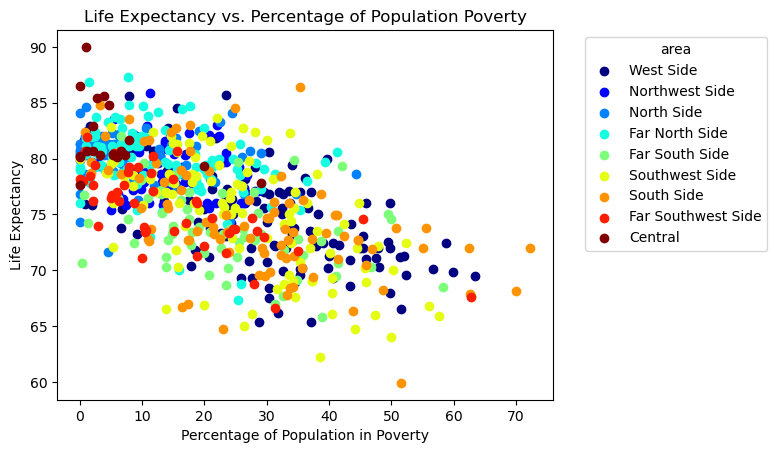

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'Neighborhood' is a column in your final_model DataFrame
# and it contains categorical data representing different neighborhoods

# Map each unique neighborhood to a color
unique_neighborhoods = final_model['area'].unique()
colors = plt.cm.jet(np.linspace(0, 1, len(unique_neighborhoods)))
neighborhood_colors = {neighborhood: color for neighborhood, color in zip(unique_neighborhoods, colors)}

# Scatter plot
for neighborhood in unique_neighborhoods:
    subset = final_model[final_model['area'] == neighborhood]
    plt.scatter(subset['Poverty'] #/ subset['Total Population']
                , subset['Life Expectancy'], 
                color=neighborhood_colors[neighborhood], label=neighborhood)

plt.xlabel('Percentage of Population in Poverty')
plt.ylabel('Life Expectancy')
plt.title('Life Expectancy vs. Percentage of Population Poverty')
plt.legend(title='area', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


In [22]:
# Grouping data by 'Area' and calculating mean 'Life Expectancy' for each area
area_life_expectancy = model.groupby('area')['Life Expectancy'].mean().sort_values(ascending=False)

# Displaying the mean 'Life Expectancy' by area
area_life_expectancy

area
Central               81.770000
North Side            80.153425
Far North Side        79.745455
Northwest Side        79.220313
Far Southwest Side    75.572917
Southwest Side        75.083962
West Side             74.928571
South Side            74.452747
Far South Side        73.631343
Name: Life Expectancy, dtype: float64

We can see there is a significant difference in LE across the various areas of the city

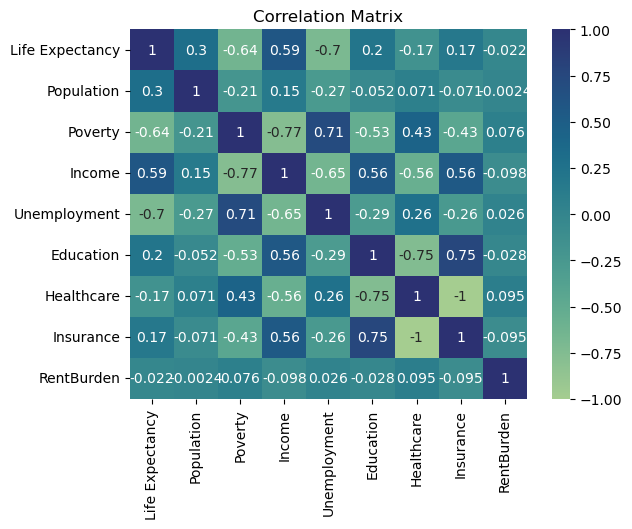

In [24]:
#corr matrix, in color
corr_model=model[['Life Expectancy','Population','Poverty','Income','Unemployment','Education','Healthcare','Insurance','area','RentBurden']]
import seaborn as sns
corr = corr_model.corr()
sns.heatmap(corr, cmap="crest",center=0, annot=True)
plt.title('Correlation Matrix')
plt.show()

### We can see from above that the catagories most significant to life expectancy are Population, Poverty, Unemployment, Education and Insurance
### We will dive deeper into these catagories using the data dictionary above in our final model

Mean Squared Error: 9.654423695893136
R-squared: 0.4915436992483916


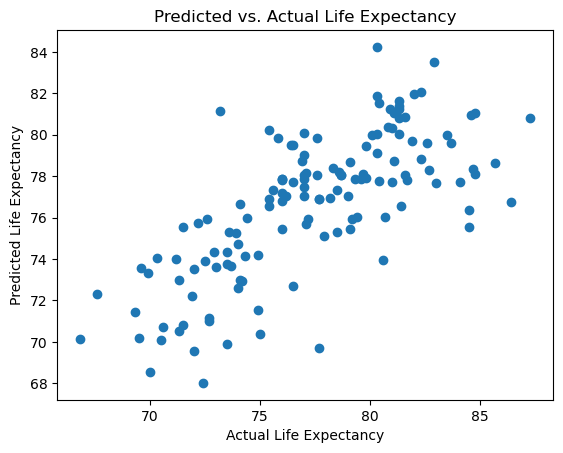

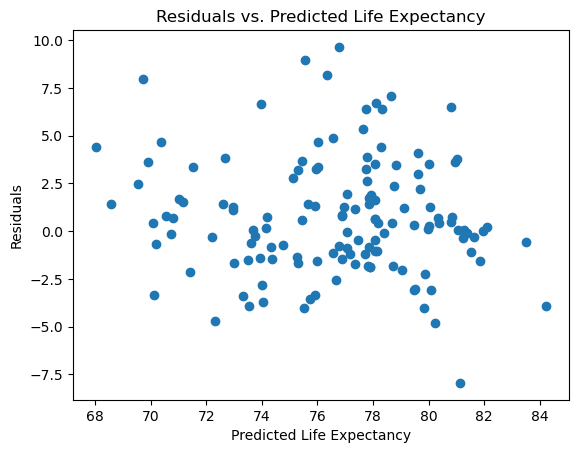

In [ ]:
#Linear Regression
model_reset=model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Splitting the data into training and testing sets
X = model[['Population', 'Poverty', 'Income', 'Unemployment', 'Education', 'Healthcare', 'Insurance']]
y = model['Life Expectancy']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating a Linear Regression model
model = LinearRegression()

# Fitting the model to the training data
model.fit(X_train, y_train)

# Making predictions using the testing data
y_pred = model.predict(X_test)

# Calculating the mean squared error
mse = mean_squared_error(y_test, y_pred)

# Calculating the R-squared value
r2 = r2_score(y_test, y_pred)

# Displaying the mean squared error and R-squared value
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Plotting the predicted values against the actual values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Life Expectancy')
plt.ylabel('Predicted Life Expectancy')
plt.title('Predicted vs. Actual Life Expectancy')
plt.show()

# Plotting the residuals
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Life Expectancy')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Life Expectancy')
plt.show()

model=model_reset

Mean Squared Error: 11.077134218716148
R-squared: 0.4166157540637718


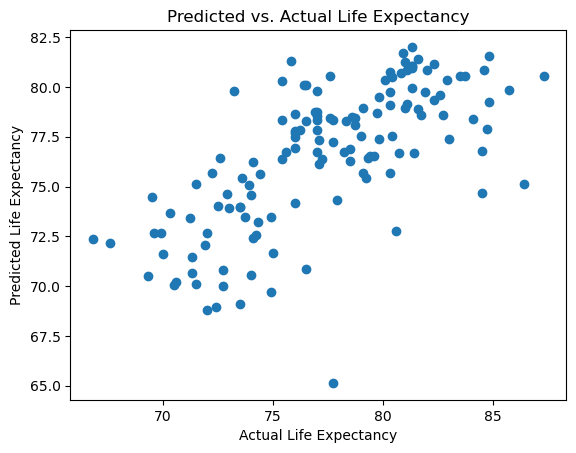

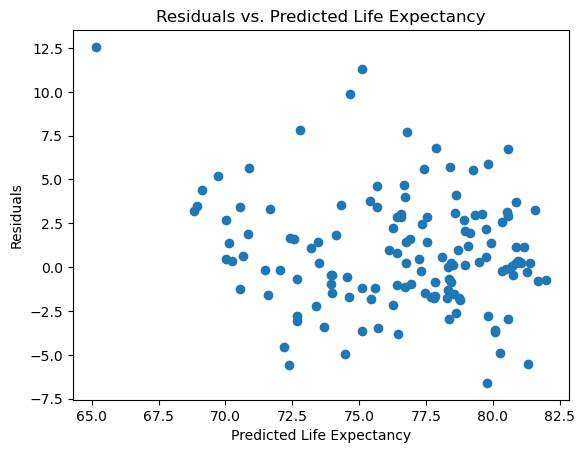

In [ ]:
#non linear regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Creating a Polynomial Regression model
degree = 2
model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

# Fitting the model to the training data
model.fit(X_train, y_train)

# Making predictions using the testing data
y_pred = model.predict(X_test)

# Calculating the mean squared error
mse = mean_squared_error(y_test, y_pred)

# Calculating the R-squared value
r2 = r2_score(y_test, y_pred)

# Displaying the mean squared error and R-squared value
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Plotting the predicted values against the actual values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Life Expectancy')
plt.ylabel('Predicted Life Expectancy')
plt.title('Predicted vs. Actual Life Expectancy')
plt.show()

# Plotting the residuals
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Life Expectancy')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Life Expectancy')
plt.show()

### Linear regressions might not be the best approach to understand life expectency, we will explore other options in the final model. Like trees, logistic regression, and non linear models